# Load and cleaning data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

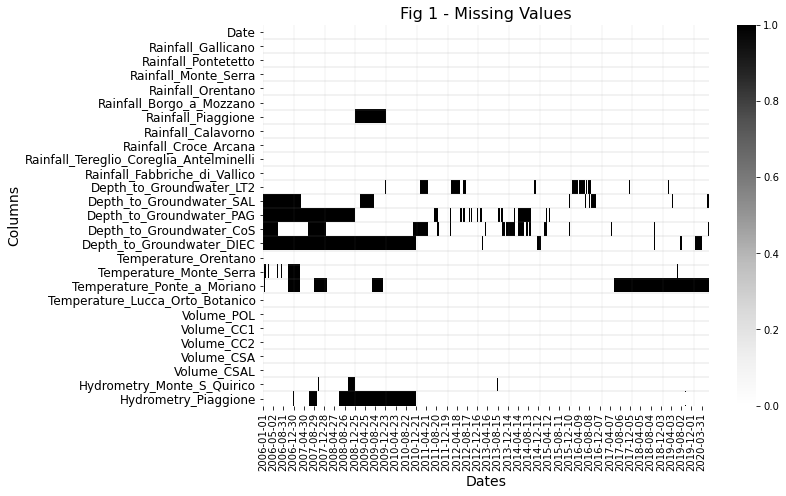

In [2]:
from datetime import datetime, date
# LOADING DATA
def load_data(name):
    df = pd.read_csv(f"../input/acea-water-prediction/Aquifer_{name}.csv")
    # Read date in european format
    df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
    return df

def load_Auser():
    aquifer = load_data("Auser")
    # CLEANING DATA
    #Replacing 0 values in well depth and temperatures with NaN
    # because they are actually  missing values
    for col in aquifer.columns[11:20]:
        aquifer[col] = aquifer[col].replace([0],float('nan'))
    #Getting indexes where the condition (NaN values for Rainfall_Gallicano) is true
    nan_rain = aquifer[aquifer.iloc[:,1].isnull()].index
    #dropping these indexes with NaN values
    aquifer = aquifer.drop(nan_rain)
    #resetting the index (without adding a new column)
    aquifer = aquifer.reset_index(drop=True)
    #There are some nan in Rainfall_Monte_Serra, but they are not so important
    aquifer["Rainfall_Monte_Serra"] = aquifer["Rainfall_Monte_Serra"].fillna(0)
    return aquifer
# FIND MISSING VALUES
def show_missing(df):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
    #Set all the labels on y axis with yticklabels=True
    sns.heatmap(df.T.isna(), cmap='Greys')
    ax.set_title('Fig 1 - Missing Values', fontsize=16)
    ax.set_xlabel("Dates", fontsize=14)
    ax.set_ylabel("Columns", fontsize=14)
    #Extracting x-labels as numbers    
    x_labels = [int(tick.get_text()) for tick in ax.get_xticklabels()]
    #Converting indexes to dates
    new_labels = df["Date"].iloc[x_labels]
    new_labels = new_labels.astype('string') #as strinf for best formatting
    #Setting the new labels
    ax.set_xticklabels(new_labels)
    #Setting font size for y labels
    for i in ax.yaxis.get_major_ticks():
        i.label.set_fontsize(12)    
    #Adding horizontal and vertical lines (very customizable)
    ax.hlines(range(1,df.shape[1]),0,df.shape[0], linewidth=0.2, colors='gray')
    ax.vlines(range(1,df.shape[0],365),0,df.shape[1], linewidth=0.1, colors='gray')
    plt.show()

aquifer = load_Auser()
show_missing(aquifer)

# Missing data in rainfall
Rainfall data are not bad, we need just ti recover Rainfall_Piaggione (or drop it). We try with a linear regression

In [3]:
def get_std_errors(X_old):
    X = X_old.copy()
    X["intercept"] = 1
    df = X.transpose().dot(X)
    inv = pd.DataFrame(np.linalg.pinv(df.values), df.columns, df.index)
    return np.sqrt(np.diag(inv))

# Print coefficients and Z score as a formatted table
def get_coef_table(reg, features, X_train):
    std_errors =  get_std_errors(X_train)
    format = "%-30s | %+2.5f | %+2.3f"
    format_title = "%-30s | %8s | %6s"
    print (format_title %("feature","coef","Z score"))
    print ("-"*38)
    for i in range((len(features))):
        print(format%(features[i][:30],reg.coef_[i],reg.coef_[i]/std_errors[i]))
    print("Intercept:\n", reg.intercept_)

Predicting Rainfall_Piaggione. R^2 on train = 0.847
Predicting Rainfall_Piaggione. R^2 on test  = 0.849
feature                        |     coef | Z score
--------------------------------------
Rainfall_Gallicano             | -0.05805 | -15.991
Rainfall_Pontetetto            | +0.31901 | +98.211
Rainfall_Monte_Serra           | +0.00000 | +0.000
Rainfall_Orentano              | +0.01954 | +5.713
Rainfall_Borgo_a_Mozzano       | +0.32896 | +92.142
Rainfall_Calavorno             | +0.17853 | +37.476
Rainfall_Croce_Arcana          | +0.00000 | +0.000
Rainfall_Tereglio_Coreglia_Ant | -0.00000 | -0.000
Rainfall_Fabbriche_di_Vallico  | +0.11423 | +33.151
Intercept:
 0.0


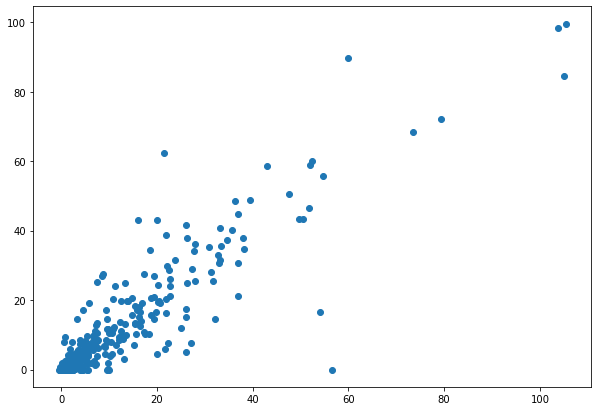

In [4]:
#just rainfall columns without nan values
aquifer = load_Auser()
rain_cols = [col for col in aquifer.columns if col[0:9]=="Rainfall_"]
rain_aquifer = aquifer[rain_cols]
rain_aquifer = rain_aquifer.dropna()
rain_aquifer = rain_aquifer.reset_index(drop=True)

#extract train and test
train = rain_aquifer.sample(frac=0.8,random_state=42) #random state is a seed value
test = rain_aquifer.drop(train.index)
y_train = train["Rainfall_Piaggione"]
y_test = test["Rainfall_Piaggione"]
rain_cols.remove('Rainfall_Piaggione')
x_train = train[rain_cols]
x_test = test[rain_cols]

#fit the model
from sklearn.linear_model import Lasso
# no intercept beacause i want to predict no rain if it rains nowhere
# alpha=2 beacause all coefficients need to be positive
# it make no sense that more rain in a location implies less rain in an other
model = Lasso(alpha=2, fit_intercept=False) 
reg = model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Predicting Rainfall_Piaggione. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting Rainfall_Piaggione. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
get_coef_table(reg,rain_cols, x_train)
fig = plt.figure(figsize=(10,7))
plt.scatter(y_pred,y_test)
plt.show()

The estimation is enough for replacing the missing data

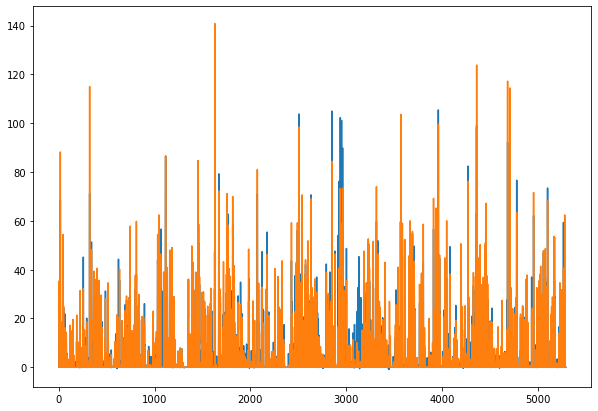

In [5]:
aquifer = load_Auser()
X = aquifer[rain_cols]
y_pred = model.predict(X)
#get index for missing values in Rainfall_Piaggione
missing_Piag = aquifer[aquifer["Rainfall_Piaggione"].isna()].index
#replace the missing data by their prediction
#using loc to avoid SettingWithCopyWarning
aquifer.loc[missing_Piag, "Rainfall_Piaggione"] = y_pred[missing_Piag]

fig = plt.figure(figsize=(10,7))
plt.plot(y_pred)
plt.plot(aquifer["Rainfall_Piaggione"])
plt.show()

# Missing data in temperature

So this is the current situation for missing data:

In [6]:
# We check missing values
for df in (aquifer,):
    print("_____________________")
    for col in df.columns:
        print("NaN values in %s = %2.5f%% " % (col, 100*df[col].isnull().sum()/df.shape[0]))

_____________________
NaN values in Date = 0.00000% 
NaN values in Rainfall_Gallicano = 0.00000% 
NaN values in Rainfall_Pontetetto = 0.00000% 
NaN values in Rainfall_Monte_Serra = 0.00000% 
NaN values in Rainfall_Orentano = 0.00000% 
NaN values in Rainfall_Borgo_a_Mozzano = 0.00000% 
NaN values in Rainfall_Piaggione = 0.00000% 
NaN values in Rainfall_Calavorno = 0.00000% 
NaN values in Rainfall_Croce_Arcana = 0.00000% 
NaN values in Rainfall_Tereglio_Coreglia_Antelminelli = 0.00000% 
NaN values in Rainfall_Fabbriche_di_Vallico = 0.00000% 
NaN values in Depth_to_Groundwater_LT2 = 9.34844% 
NaN values in Depth_to_Groundwater_SAL = 14.35316% 
NaN values in Depth_to_Groundwater_PAG = 28.10198% 
NaN values in Depth_to_Groundwater_CoS = 18.58357% 
NaN values in Depth_to_Groundwater_DIEC = 38.24363% 
NaN values in Temperature_Orentano = 0.01889% 
NaN values in Temperature_Monte_Serra = 4.45703% 
NaN values in Temperature_Ponte_a_Moriano = 29.06516% 
NaN values in Temperature_Lucca_Orto_Botan

In [7]:
x_test.isna().sum()

Rainfall_Gallicano                         0
Rainfall_Pontetetto                        0
Rainfall_Monte_Serra                       0
Rainfall_Orentano                          0
Rainfall_Borgo_a_Mozzano                   0
Rainfall_Calavorno                         0
Rainfall_Croce_Arcana                      0
Rainfall_Tereglio_Coreglia_Antelminelli    0
Rainfall_Fabbriche_di_Vallico              0
dtype: int64

Predicting Temperature_Monte_Serra. R^2 on train = 0.908
Predicting Temperature_Monte_Serra. R^2 on test  = 0.910
feature                        |     coef | Z score
--------------------------------------
Temperature_Orentano           | +0.32210 | +16.904
Temperature_Lucca_Orto_Botanic | +0.57248 | +30.440
Intercept:
 -2.1792886240062685


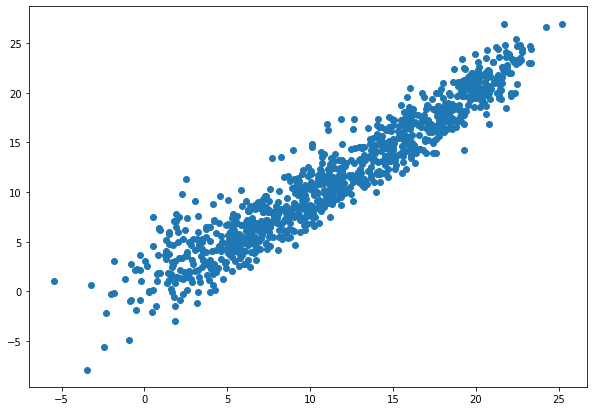

In [8]:
#missing data for Ponte a Moriano are too much, we discard the whole column:**
del aquifer["Temperature_Ponte_a_Moriano"]
#missing data for Lucca_Orto_Botanico and Orentano are very few, we replace them by median
aquifer["Temperature_Orentano"] = aquifer["Temperature_Orentano"].fillna(aquifer["Temperature_Orentano"].median())
aquifer["Temperature_Lucca_Orto_Botanico"] = aquifer["Temperature_Lucca_Orto_Botanico"].fillna(aquifer["Temperature_Lucca_Orto_Botanico"].median())
#We use prediction again for Monte Serra
temp_cols = [col for col in aquifer.columns if col[0:12]=="Temperature_"]
temp_aquifer = aquifer[temp_cols].dropna()
train = temp_aquifer.sample(frac=0.8,random_state=2) #random state is a seed value
test = temp_aquifer.drop(train.index)

temp_aquifer = aquifer[temp_cols]
y_train = train["Temperature_Monte_Serra"]
y_test = test["Temperature_Monte_Serra"]
temp_cols.remove('Temperature_Monte_Serra')
x_train = train[temp_cols]
x_test = test[temp_cols]



#fit the model
from sklearn.linear_model import LinearRegression
#no need for a Lasso
model = LinearRegression() 
reg = model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Predicting Temperature_Monte_Serra. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting Temperature_Monte_Serra. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
get_coef_table(reg,temp_cols, x_train)
fig = plt.figure(figsize=(10,7))
plt.scatter(y_pred,y_test)
plt.show()

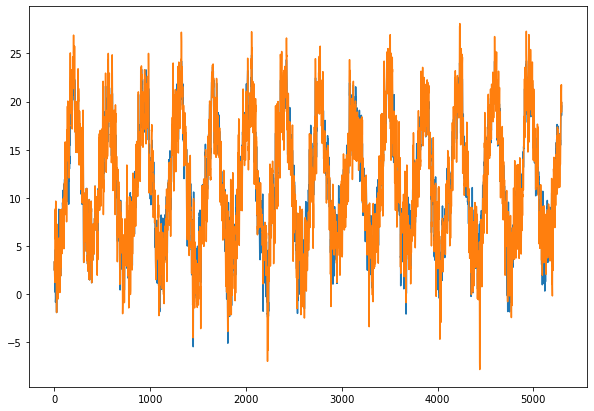

In [9]:
X = aquifer[temp_cols]
y_pred = model.predict(X)
#get index for missing values in Temperature_Monte_Serra
missing_Mont = aquifer[aquifer["Temperature_Monte_Serra"].isna()].index
#replace the missing data by their prediction
#using loc to avoid SettingWithCopyWarning
aquifer.loc[missing_Mont, "Temperature_Monte_Serra"] = y_pred[missing_Mont]

fig = plt.figure(figsize=(10,7))
plt.plot(y_pred)
plt.plot(aquifer["Temperature_Monte_Serra"])
plt.show()

In [10]:
# We check missing values
for df in (aquifer,):
    print("_____________________")
    for col in df.columns:
        print("NaN values in %s = %2.5f%% " % (col, 100*df[col].isnull().sum()/df.shape[0]))

_____________________
NaN values in Date = 0.00000% 
NaN values in Rainfall_Gallicano = 0.00000% 
NaN values in Rainfall_Pontetetto = 0.00000% 
NaN values in Rainfall_Monte_Serra = 0.00000% 
NaN values in Rainfall_Orentano = 0.00000% 
NaN values in Rainfall_Borgo_a_Mozzano = 0.00000% 
NaN values in Rainfall_Piaggione = 0.00000% 
NaN values in Rainfall_Calavorno = 0.00000% 
NaN values in Rainfall_Croce_Arcana = 0.00000% 
NaN values in Rainfall_Tereglio_Coreglia_Antelminelli = 0.00000% 
NaN values in Rainfall_Fabbriche_di_Vallico = 0.00000% 
NaN values in Depth_to_Groundwater_LT2 = 9.34844% 
NaN values in Depth_to_Groundwater_SAL = 14.35316% 
NaN values in Depth_to_Groundwater_PAG = 28.10198% 
NaN values in Depth_to_Groundwater_CoS = 18.58357% 
NaN values in Depth_to_Groundwater_DIEC = 38.24363% 
NaN values in Temperature_Orentano = 0.00000% 
NaN values in Temperature_Monte_Serra = 0.00000% 
NaN values in Temperature_Lucca_Orto_Botanico = 0.00000% 
NaN values in Volume_POL = 0.00000% 
Na

# Ten days predictions

In [11]:
from patsy import dmatrices, dmatrix, demo_data
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x,pd.Series):
        return x.shift(n)
    x = x.copy()
    if n>0:
        x[n:] = x[0:-n]
        x[:n] = np.nan
    else:
        x[:-n] = x[n:]
        x[-n:] = np.nan
    return x

def lag_all(x, n):
    out = x.copy()
    if isinstance(x,pd.Series):
        out = x.values    
    for i in range(np.sign(n),n,np.sign(n)):
        x_i = lag(x,i)
        out = np.vstack((out,x_i))
    return out.T



In [65]:
from patsy import dmatrices, dmatrix, demo_data

import numpy as np
dataset = np.arange(365)
y = dmatrix("cc(x, df=6) - 1", {"x": dataset})
print(y)

[[ 1.00000000e+00  8.74300632e-17 -2.49800181e-17  1.24900090e-17
  -2.49800181e-17  8.74300632e-17]
 [ 9.92186326e-01  5.33600467e-02 -1.34568829e-02  6.90096558e-04
   1.06964966e-02 -4.34760831e-02]
 [ 9.69813841e-01  1.15401953e-01 -2.90508390e-02  2.58229680e-03
   1.87216518e-02 -7.74689039e-02]
 [ 9.34485349e-01  1.84522915e-01 -4.59804658e-02  5.40946657e-03
   2.43425995e-02 -1.02779865e-01]
 [ 8.87803656e-01  2.59120127e-01 -6.34443610e-02  8.90447171e-03
   2.78264741e-02 -1.20210368e-01]
 [ 8.31371567e-01  3.37590784e-01 -8.06411220e-02  1.28001781e-02
   2.94404096e-02 -1.30561817e-01]
 [ 7.66791886e-01  4.18332081e-01 -9.67693464e-02  1.68294515e-02
   2.94515402e-02 -1.34635612e-01]
 [ 6.95667418e-01  4.99741214e-01 -1.11027632e-01  2.07251579e-02
   2.81270000e-02 -1.33233158e-01]
 [ 6.19600968e-01  5.80215377e-01 -1.22614576e-01  2.42201631e-02
   2.57339233e-02 -1.27155856e-01]
 [ 5.40195342e-01  6.58151766e-01 -1.30728775e-01  2.70473328e-02
   2.25394440e-02 -1.1720

In [12]:
def extract_col(df, substr):
    return [col for col in df.columns if col[0:len(substr)]==substr]

def format_rain(aquifer_old,days):
    aquifer = aquifer_old.copy()
    #Calculating total rain
    rain_name = extract_col(aquifer, 'Rainfall_')
    #aquifer["tot_rain"] = aquifer[rain_name].sum(axis=1)

    max_day_before = days #select how long keep old rain record
    for d in range(1, max_day_before+2):
        for col in rain_name:
            aquifer[col+"_"+str(d)] = aquifer[col].shift(d)
    temp_name = extract_col(aquifer, 'Temperature_')
    aquifer["mean_temp"] = aquifer[temp_name].mean(axis=1)
    for d in range(1, max_day_before+2):
        aquifer["mean_temp"+"_"+str(d)] = aquifer["mean_temp"].shift(d)
    mean_temp_name = extract_col(aquifer, 'mean_temp')
    aquifer["tot_mean_temp"] = aquifer[mean_temp_name].mean(axis=1)
    wells_name = extract_col(aquifer, 'Depth_to_') 
    for col in wells_name:
        aquifer[col+"_old_"+str(max_day_before)] = aquifer[col].shift(max_day_before)
        aquifer[col+"_delta_"+str(max_day_before)] = aquifer[col] - aquifer[col+"_old_"+str(max_day_before)]
    
    #Delete initial rows with Nan values
    aquifer = aquifer.iloc[max_day_before+1:]
    return aquifer

    


# Simple linear regression

[21:25:05] WARNING: ../src/learner.cc:541: 
Parameters: { loss, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Predicting delta depth. R^2 on train = 0.885
Predicting delta depth. R^2 on test  = 0.749
mean squared error on test  = 0.221
R2 score on test  = 0.749


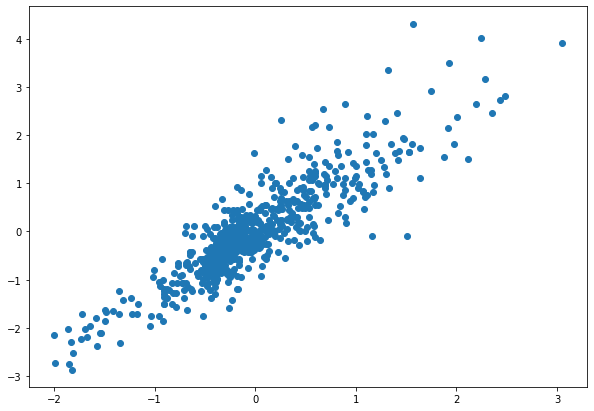

2.145681591440302 1.9132283
1.9138825412014664 1.4788878
0.6969375274475789 0.56849164
-1.707977618780341 -1.3562526
-0.11435914838834575 -0.2538626
-1.7079776187803413 -1.1727906
-1.2154046370228153 -0.8595822
1.2474602717648133 0.79081905
-2.7220984635752474 -1.9948694
-0.9256558242242711 -0.5678181
-0.8677060616645621 -0.57745
0.9577114589662685 0.6887453
1.1605356279252506 0.5479716
-2.2005506005378668 -1.6765326
-1.2733543995825243 -0.8175758
-0.7228316552652896 0.0675771
0.001540376731071861 0.44717383
0.030515258010926347 -0.20509773
-0.40410796118689024 -0.051566098
-0.4330828424667454 -0.07685308
-0.34615819862718133 -0.13978104
-0.5489823675861627 -0.36901432
-0.6359070114257261 -0.515673
-0.5779572488660172 -0.43291956
-0.5779572488660178 -0.3923648
-0.11435914838834607 -0.098180644
-0.0564093858286371 -0.11825412
-0.0564093858286371 -0.28992206
0.0305152580109257 -0.30129206
-0.34615819862718067 -0.43999007
-0.23025867350776402 -0.38821995
-0.31718331734732813 -0.384623
-0.

0.5810380023281609 -0.058212943
-2.02670131285874 -1.6888652
-0.5779572488660172 -0.5151748
-0.8097562991048531 -1.0091336
-0.14333402966820055 0.07816916
0.4361635959288885 -0.17962469
-0.606932130145872 -0.5192096
0.20436454569005258 -0.31308284
0.349238952089325 -0.0944235
0.05949013929078083 -0.29061878
-0.7228316552652896 -0.6552981
-1.1284799931832523 -0.95145327
-0.40410796118689024 -0.25295305
0.5230882397684526 0.24881147
-0.9546307055041255 -0.4019545
2.3195308791194287 0.25116232
2.6382545731978273 0.8874107
2.1746564727201565 0.55873245
-0.5200074863063082 -0.41088748
-0.8966809429444166 -0.7310764
-1.50515344982136 -1.1638885
-1.8528520251796137 -1.4982249
-0.8677060616645621 -0.8040602
-0.027434504548782622 -0.6982605
1.740033253522339 1.6389456
3.3626266051941887 1.3184545
4.029048874630841 2.2393029
2.928003385996373 1.7446822
-1.0415553493436884 -0.95560205
-1.2154046370228155 -0.710572
-0.5779572488660172 -0.21056132
0.7838621712871422 -0.06273237
1.6241337284029218 -

In [13]:
days = 10
aquifer_10d = format_rain(aquifer, days)
aquifer_10d
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear

well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
well_target = "Depth_to_Groundwater_SAL" #R^2 = 0.70
well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82
features_rain = extract_col(aquifer_10d, 'Rainfall_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Gallicano')
features_temp = extract_col(aquifer_10d, 'tot_mean_temp')
features_well = extract_col(aquifer_10d, well_target +"_old_"+str(days))
features_date = extract_col(aquifer_10d, 'day_year')
features =  features_rain + features_temp + features_well + features_date
target = well_target +"_delta_"+str(days)
aquifer_10d_predict = aquifer_10d[features + [target]].dropna()

aquifer_10d_predict = (aquifer_10d_predict - aquifer_10d_predict.mean())/aquifer_10d_predict.std() 


from patsy import dmatrix
def expand_bs(X_old, n_knots):
    '''
    bspline
    '''
    X = pd.DataFrame(X_old)
    first_iter = True
    for col in X.columns:
        x = X[col]
        knots = np.percentile(x, np.linspace(0,100,n_knots+2)[1:-1])
        if first_iter:
            X_expanded = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)", {"x": x},return_type='dataframe')
            first_iter = False
        else:
            X_expanded = pd.concat([X_expanded, dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)", {"x": x},return_type='dataframe')], axis=1)
    #X_expanded.columns = range(X_expanded.shape[1])
    return X_expanded

def expand_cr(X_old, df):
    '''
    natural cubic spline
    '''
    X = pd.DataFrame(X_old)
    first_iter = True
    for col in X.columns:
        x = X[col]
        x_expanded = dmatrix("cr(x, df=df)", {"x": x},return_type='dataframe')
        if first_iter:
            X_expanded = x_expanded
            first_iter = False
        else:
            X_expanded = pd.concat([X_expanded, x_expanded], axis=1)
    #X_expanded.columns = range(X_expanded.shape[1])
    return X_expanded

#split a dataset extracting some data and calculating their splines
def extract_spline(X_old, features, df, split=True):
    X = X_old.copy()
    Z = X[features].copy()
    #Z = (Z - Z.mean())/Z.std()
    for col in features:
        del X[col]
    #Z_spl = Z
    Z_spl = expand_cr(Z, df)
    #Z_spl = expand_bs(Z, df)
    for col in Z.columns:
        
        #Z_spl[str(col)+"pw1"] =  Z[col]**1
        continue
        Z_spl[str(col)+"pw2"] =  Z[col]**2
        Z_spl[str(col)+"pw3"] =  Z[col]**3
        Z_spl[str(col)+"pw4"] =  Z[col]**4
        #Z_spl[str(col)+"pw0"] =  Z[col]**0
        pass
 
    if split:
        return(X, Z_spl)
    return pd.concat([X, Z_spl], axis=1)


# Con la regressione lineare si arriva a 0.72
# Con la regressione lineare si arriva a 0.64 (O.68 sul test)


aquifer_10d_predict = extract_spline(aquifer_10d_predict, features_date, df=5, split=False)
aquifer_10d_predict = extract_spline(aquifer_10d_predict, features_temp, df=5, split=False)
aquifer_10d_predict = extract_spline(aquifer_10d_predict, [well_target +"_old_"+str(days)], df=5, split=False)

train = aquifer_10d_predict.sample(frac=0.8,random_state=1) #random state is a seed value
test = aquifer_10d_predict.drop(train.index)
features = list(aquifer_10d_predict.columns)
features.remove(target)
y_train = train[target]
y_test = test[target]
x_train = train[features]
x_test = test[features]

#fit the model
from sklearn.linear_model import LinearRegression
#no need for a Lasso
#model = Lasso(alpha=0.005) 
model = LinearRegression()
import xgboost as xgb
params = {'n_estimators': 300,
          'max_depth': 5,
          'min_samples_split': 10,
          'learning_rate': 0.01,
          'loss': 'ls'}
model = xgb.XGBRegressor(random_state=42, **params)

x_train.columns = range(x_train.shape[1])
x_test.columns = range(x_test.shape[1])
reg = model.fit(x_train, y_train)


print("Predicting delta depth. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting delta depth. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
y_pred = reg.predict(x_test)
from sklearn.metrics import mean_squared_error, r2_score

print("mean squared error on test  = %2.3f"%(mean_squared_error(y_test, y_pred)))
print("R2 score on test  = %2.3f"%(r2_score(y_test, y_pred)))
#get_coef_table(reg,features, x_train)
fig = plt.figure(figsize=(10,7))
plt.scatter(y_pred,y_test)
plt.show()
for x,y in zip(y_test,y_pred):
    print(x,y)

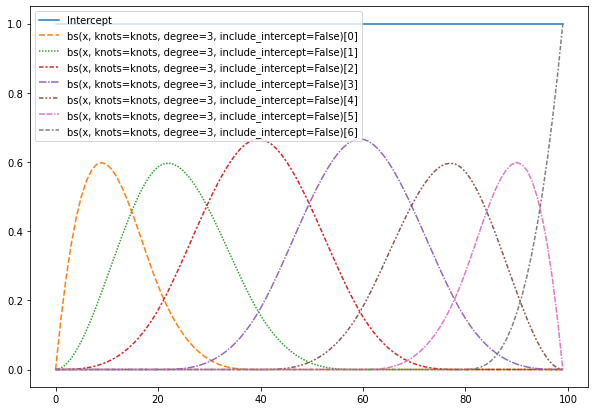

In [14]:
def expand_bs(X_old, n_knots):
    '''
    bspline
    '''
    X = pd.DataFrame(X_old)
    first_iter = True
    for col in X.columns:
        
        x = X[col]
        
        knots = np.percentile(x, np.linspace(0,100,n_knots+2)[1:-1])
        
        if first_iter:
            X_expanded = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)", {"x": x},return_type='dataframe')
            first_iter = False
        else:
            X_expanded = pd.concat([X_expanded, dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)", {"x": x},return_type='dataframe')], axis=1)
    #X_expanded.columns = range(X_expanded.shape[1])
    return X_expanded



def extract_spline(X_old, features, df, split=True):
    X = X_old.copy()
    Z = X[features].copy()
    #Z = (Z - Z.mean())/Z.std()
    for col in features:
        del X[col]
    #Z_spl = Z
    #Z_spl = expand_cr(X[col], df)
    Z_spl = expand_bs(Z, df)
    for col in Z.columns:
        
        #Z_spl[str(col)+"pw1"] =  Z[col]**1
        continue
        Z_spl[str(col)+"pw2"] =  Z[col]**2
        Z_spl[str(col)+"pw3"] =  Z[col]**3
        Z_spl[str(col)+"pw4"] =  Z[col]**4
        #Z_spl[str(col)+"pw0"] =  Z[col]**0
        pass
 
    if split:
        return(X, Z_spl)
    return pd.concat([X, Z_spl], axis=1)

x = np.linspace(0,1,100)
X = pd.DataFrame(x, columns=['x'])
A, X_sp = extract_spline(X, ['x'], 4)
type(X_sp)
fig = plt.figure(figsize=(10,7))

sns.lineplot(data=X_sp)
plt.show()

In [15]:
X_sp.iloc[:,1]

0     0.000000
1     0.140262
2     0.258920
3     0.357327
4     0.436834
        ...   
95    0.000000
96    0.000000
97    0.000000
98    0.000000
99    0.000000
Name: bs(x, knots=knots, degree=3, include_intercept=False)[0], Length: 100, dtype: float64

# Two step regression

In [16]:
days = 10
aquifer_10d = format_rain(aquifer, days)
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear

well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
#well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82
features_rain = extract_col(aquifer_10d, 'Rainfall_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Gallicano')
features_temp = extract_col(aquifer_10d, 'tot_mean_temp')
features_well = extract_col(aquifer_10d, well_target +"_old_"+str(days))
features_date = extract_col(aquifer_10d, 'day_year')
features =  features_rain + features_temp + features_well + features_date
target = well_target +"_delta_"+str(days)
aquifer_10d_predict = aquifer_10d[features + [target]].dropna()



# Con la regressione lineare si arriva a 0.72
# Con la regressione lineare si arriva a 0.64 (O.68 sul test)


just_rain = aquifer_10d_predict[features_rain + features_date + features_well]
just_rain = extract_spline(just_rain, features_date, df=4, split=False)
just_rain = extract_spline(just_rain, [well_target +"_old_"+str(days)], df=4, split=False)
rain_model = LinearRegression() 
rain_reg = rain_model.fit(just_rain, aquifer_10d_predict[target])
print("Predicting with just rain. R^2= %2.3f"%(rain_reg.score(just_rain, aquifer_10d_predict[target])))
rain_prediction = rain_model.predict(just_rain)
without_rain = aquifer_10d_predict[features_temp  + [target]].copy()

without_rain["rain_prediction"] = rain_prediction







without_rain = extract_spline(without_rain, features_temp, df=4, split=False)


train = without_rain.sample(frac=0.8,random_state=3) #random state is a seed value
test = without_rain.drop(train.index)
features = list(without_rain.columns)
features.remove(target)
y_train = train[target]
y_test = test[target]
x_train = train[features]
x_test = test[features]

#fit the model
from sklearn.linear_model import LinearRegression
#no need for a Lasso
model = LinearRegression() 
reg = model.fit(x_train, y_train)
x2_test = model.predict(x_test)
x2_train = model.predict(x_train)



print("Predicting delta depth. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting delta depth. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
get_coef_table(reg,features, x_train)
fig = plt.figure(figsize=(10,7))
#plt.scatter(y_pred,y_test)
plt.show()


Predicting with just rain. R^2= 0.725
Predicting delta depth. R^2 on train = 0.725
Predicting delta depth. R^2 on test  = 0.749
feature                        |     coef | Z score
--------------------------------------
rain_prediction                | +0.97059 | +14.031
Intercept                      | +0.00000 | +0.000
bs(x, knots=knots, degree=3, i | +0.05791 | +0.119
bs(x, knots=knots, degree=3, i | +0.14153 | +0.471
bs(x, knots=knots, degree=3, i | +0.11188 | +0.308
bs(x, knots=knots, degree=3, i | +0.15086 | +0.456
bs(x, knots=knots, degree=3, i | +0.06078 | +0.166
bs(x, knots=knots, degree=3, i | +0.12045 | +0.336
bs(x, knots=knots, degree=3, i | -0.07361 | -0.182
Intercept:
 -0.10545528529941889


<Figure size 720x504 with 0 Axes>

In [17]:
print(x_train.columns)

def graph_dependecies(reg, x_train, name_feat):
    features = list(x_train.columns)
    features_well = extract_col(x_train, name_feat)
    coeff_indexes = [features.index(col )for col in features_well]
    y_part = x_train[features_well] @ reg.coef_[coeff_indexes]
    x_part = x_train[features_well[0]]
    fig = plt.figure()
    ax = plt.axes()
    print(y_part.mean())
    ax.scatter(x_part,y_part);
    ax.set_title(name_feat)
    plt.show()
#graph_dependecies(reg, x_train, well_target +"_old_")
graph_dependecies(reg, x_train, "tot_mean_temp")
#graph_dependecies(reg, x_train, "rain")

Index(['rain_prediction', 'Intercept',
       'bs(x, knots=knots, degree=3, include_intercept=False)[0]',
       'bs(x, knots=knots, degree=3, include_intercept=False)[1]',
       'bs(x, knots=knots, degree=3, include_intercept=False)[2]',
       'bs(x, knots=knots, degree=3, include_intercept=False)[3]',
       'bs(x, knots=knots, degree=3, include_intercept=False)[4]',
       'bs(x, knots=knots, degree=3, include_intercept=False)[5]',
       'bs(x, knots=knots, degree=3, include_intercept=False)[6]'],
      dtype='object')


IndexError: list index out of range

In [ ]:
import numpy as np
import pandas as pd
import scipy.linalg
import sklearn.linear_model
import sklearn.metrics
class BilinearRegression:    
    def __init__(self, *, constant_terms=True, max_sd_iter=100, sd_prec=1e-5):
        self.constant_terms = constant_terms
        self.max_sd_iter = max_sd_iter
        self.sd_prec = sd_prec
        self._is_fitted = False
    @staticmethod
    def _first_projection(X, Q1, Q2):
        '''First projection using the aproximation :math:`Q = Q1 \otimes Q2`
        '''
        Q1_norm = np.linalg.norm(Q1)
        Q2_norm = np.linalg.norm(Q2)                                
        Q1 = Q1 + np.identity(len(Q1))*Q1_norm*1e-4/(len(Q1))
        Q2 = Q2 + np.identity(len(Q2))*Q2_norm*1e-4/(len(Q2))
        sqrt_Q1 = scipy.linalg.sqrtm(Q1)
        sqrt_Q2 = scipy.linalg.sqrtm(Q2)
        U,D,VT = np.linalg.svd(sqrt_Q1 @ X @ sqrt_Q2, full_matrices=False)
        D[1:] = 0
        return np.linalg.pinv(sqrt_Q1) @ U @ np.diag(D) @ VT @ np.linalg.pinv(sqrt_Q2)
    @staticmethod
    def _frobenius_project_to_dyad(M):
        U,D,VT = np.linalg.svd(M, full_matrices=False)
        D[1:] = 0
        return U @ np.diag(D) @ VT
    @staticmethod
    def _dyad_decomposition(D):
        v1 = D[:,0]/D[0,0]
        v2 = D[0]
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)
        #Normalize the vectors for more stability and simmetry
        v1, v2 = v1*np.sqrt(v1_norm*v2_norm)/v1_norm, v2*np.sqrt(v1_norm*v2_norm)/v2_norm
        return [v1, v2]
    @staticmethod
    def _get_R(Q_inv, X, N):
        n = X.shape[0]
        NI_n = np.kron(N,np.identity(n))
        R = BilinearRegression.vec(X) - Q_inv @ NI_n @ np.linalg.pinv( NI_n.T @ Q_inv @ NI_n ) @ NI_n.T @ BilinearRegression.vec(X)
        return BilinearRegression.mat(R, X.shape[0], X.shape[1])

    # Vectorize a numpy matrix/array
    @staticmethod
    def vec(M):
        return M.T.reshape(M.shape[0]*M.shape[1],1)
    @staticmethod
    def mat(v,n,m):
        return v.reshape(m, n).T
    @staticmethod
    def _f(N, Q_inv, X, get_S=False):
        n = X.shape[0]
        In = np.identity(n)
        NI_n = np.kron(N,In)
        S = np.linalg.pinv( NI_n.T @ Q_inv @ NI_n )
        fN = BilinearRegression.vec( X @ N ).T @ S @ BilinearRegression.vec( X @ N )
        if get_S:
            return fN, S   
        return fN

    @staticmethod    
    def _project_to_dyad(X, Q, max_sd_iter=200, sd_prec=1e-5, R_0=None):
        """
        Find a matrix R of rank one which minimize ||X-R||_Q using a SD algorithm, where ||X-R||_Q = vec(X-R).T @ Q @ vec(X-R) 
        Source: Algorithm 11 from "The geometry of weighted low-rank approximations", March 2003, IEEE Transactions on Signal Processing 51(2)(2), pp. 500 - 514 
        Parameters
        ----------
        X : {array-like} of shape (n, m)
            Matrix to aproximate
        Q : {array-like} of shape (nm, nm) positive definite symmetric matrix
            Weighting matrix
        R : {array-like} of shape (n, m) and rank one, (optional)
            Starting matrix    
        max_sd_iter : {positive integer} maximal number of iteration in the SD algorithm, default=100
        sd_prec : {positive float} minimal precision in the SD algorithm, default=1e-5
        Returns
        -------
        R : returns a (n, m) matrix of rank one
        """    
        [n, m] = X.shape
        # We add some values on the diagonal for avoiding almost_null eigenvalues (which make Q_inv instable)
        # We can use it also to obtain some ridge like algorithm
        Q_norm = np.linalg.norm(Q)
        Q = Q + np.identity(m*n)*Q_norm*1e-9/(n*m)        

        # step 1
        # the starting R is calculated using Frobenius norm
        if R_0 is None:
            R = BilinearRegression._frobenius_project_to_dyad(X)
        else:
            R = R_0
                #we need n>=m for the algorithm
        R = np.real(R)
        if m>n:            
            #print(BilinearRegression.vec(X).T @ Q @ BilinearRegression.vec(X))
            X = X.T #Transposing T
            R = R.T #Transposing R
            # Adjust the Q matrix accordingly (a bit tricky with indices)
            new_Q = Q.copy()            
            for i in range (m*n):
                for j in range(m*n):
                    new_Q[i,j] = Q[(i%m)*n+i//m,(j%m)*n+j//m] 
            Q = new_Q
            [n, m] = [m, n]
            is_transposed = True
            #print(BilinearRegression.vec(X).T @ Q @ BilinearRegression.vec(X))
        else:
            is_transposed = False         
        Q_inv = np.linalg.pinv(Q)
        N = scipy.linalg.null_space(R)
        q,r = np.linalg.qr(N, mode="complete")
        N = q[:,:-1]
        N_ort= q[:,-1:]
        for time in range(max_sd_iter):    
            l = 1
            # step 2 - evaluate f(N)
            fN, S = BilinearRegression._f(N,Q_inv, X ,get_S=True)
            print("f(N): %2.5f"%fN)
            NI_n = np.kron(N,np.identity(n))
            # step 3 - compute descent direction
            A = BilinearRegression.mat( S @ BilinearRegression.vec( X @ N ), n, m-1)
            B = BilinearRegression.mat( Q_inv @ BilinearRegression.vec(A @ N.T), n, m )
            K = -2 * N_ort.T @ (X - B).T @ A
            norm_K = np.linalg.norm(K)**2
            # step 4 - increase l
            while (fN - BilinearRegression._f(N + 2*l*N_ort@K, Q_inv, X)) >= l*norm_K:
                l = 2*l
            # step 5 - decrease l
            while (fN - BilinearRegression._f(N + l*N_ort@K,Q_inv, X)) < 0.5*l*norm_K:
                l = 0.5*l
            # step 6 - calculating new R and new N matrix
            #print("l:%2.15f"%l)
            N = N + l*N_ort@K
            q,r = np.linalg.qr(N, mode="complete")
            N = q[:,:-1]
            N_ort= q[:,-1:]
            old_R = R
            R = BilinearRegression._get_R(Q_inv, X, N)
            if ((time>1) and (old_fN-fN) < fN*sd_prec) and (np.linalg.norm(old_R - R) < np.linalg.norm(R)*(sd_prec/(n*m))):
                break
            old_fN = fN    
        if is_transposed:
            R = R.T
        return R

    
    def predict(self, X, Z):
        assert X.shape[0] == Z.shape[0], "The lengths of features dataframes are not the same"
        assert X.shape[1] == len(self.coef_[0]), "The number of features in the first dataset do not correspond to the fitted model"
        assert Z.shape[1] == len(self.coef_[1]), "The number of features in the second dataset do not correspond to the fitted model"
        y_pred = (X @ self.coef_[0] + self.constants_[0]) * (Z @ self.coef_[1] + self.constants_[1])
        return y_pred
    
    def right_predict(self, Z):
        """Return the contribution to prediction of the right term (useful for plotting variable dependency) 
        """
        assert Z.shape[1] == len(self.coef_[1]), "The number of features in the second dataset do not correspond to the fitted model"
        y_pred = Z @ self.coef_[1] + self.constants_[1]
        return y_pred
    
    def left_predict(self, Z):
        """Return the contribution to prediction of the left term (useful for plotting variable dependency) 
        """
        assert Z.shape[1] == len(self.coef_[1]), "The number of features in the second dataset do not correspond to the fitted model"
        y_pred = X @ self.coef_[0] + self.constants_[0]
        return y_pred
    
    def score(self, X, Z, y):
        """Return the coefficient of determination :math:`R^2` of the
        prediction.
        """
        y_pred = self.predict(X, Z)
        return sklearn.metrics.r2_score(y, y_pred)
    
    def fit(self, X_orig, Z_orig, y):
        """
        Fit a bilinear model in the form y = (a*X_orig + c) * (b*Z_orig + d) (with c==d==0  if constant_terms==False), 
        using projection on rank one matrix
        Parameters
        ----------
        X_orig : {pandas DataFrame} of shape (n_samples, n_features)
            Training data
        Z_orig : {pandas DataFrame} of shape (m_samples, n_features)
            Training data    
        y : array-like (n_samples,) Target values. Will be cast to X's dtype if necessary
        
        Returns
        -------
        self : returns an instance of self.
        """    
        #Verify the dataset length is the same for both X, Z and Y
        assert X_orig.shape[0] == Z_orig.shape[0], "The lengths of features dataframes are not the same"
        assert X_orig.shape[0] == y.shape[0], "The lengths of features and predictions are not the same"
        X = X_orig.copy()
        Z = Z_orig.copy()
        if self.constant_terms==True:
            X["costant"] = 1
            Z["costant"] = 1             
        #Taking all the products of X and Z
        p1 = X.shape[1]
        p2 = Z.shape[1]
        XZ = []
        for feat1 in Z.columns:
            for feat2 in X.columns:
                XZ.append(Z[feat1]*X[feat2])
        XZ = pd.DataFrame(XZ).transpose()
        cov = XZ.transpose() @ XZ
        cov = cov.to_numpy()
        Q1 = X.T @ X
        Q2 = Z.T @ Z
        #Linear regression
        model = sklearn.linear_model.LinearRegression(fit_intercept=False)
        reg = model.fit(XZ, y)
        #print("Linear score for the expanded basis: ",reg.score(XZ, y_obs))
        # Convert regression coefficients into matrix
        beta = BilinearRegression.mat(reg.coef_, p1, p2)
        # Initialising R in this way give a good boost in initial precision since Q is almost Q2 tensor Q1
        R = BilinearRegression._first_projection(beta, Q1, Q2)
        R = BilinearRegression._project_to_dyad(beta, cov, max_sd_iter = self.max_sd_iter, sd_prec=self.sd_prec, R_0 = R)
        coef = BilinearRegression._dyad_decomposition(R) 
        if self.constant_terms:
            self.coef_ = [coef[0][:-1], coef[1][:-1]]
            self.constants_ = [coef[0][-1], coef[1][-1]]
        else:
            self.coef_ = coef
            self.constants_ = [0, 0] 
        self._is_fitted = True
        return self

# Bilinear Regression

In [ ]:
days = 10
aquifer_10d = format_rain(aquifer, days)
aquifer_10d

well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
#well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82
features_rain = extract_col(aquifer_10d, 'Rainfall_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Gallicano')
features_temp = extract_col(aquifer_10d, 'tot_mean_temp')
features = features_rain + features_temp + [well_target +"_old_"+str(days)]
target = well_target +"_delta_"+str(days)
aquifer_10d_predict = aquifer_10d[features + [target]].dropna()



aquifer_10d_predict = extract_spline(aquifer_10d_predict, features_temp, df=4, split=False)
#aquifer_10d_predict = extract_spline(aquifer_10d_predict, [well_target +"_old_"+str(days)], df=4, split=False)
# Con la regressione lineare si arriva a 0.72
# Con la regressione lineare si arriva a 0.64 (O.68 sul test)

train = aquifer_10d_predict.sample(frac=0.8,random_state=34) #random state is a seed value
test = aquifer_10d_predict.drop(train.index)
features = list(aquifer_10d_predict.columns)
features.remove(target)
y_train = train[target]
y_test = test[target]
x_train = train[features]
x_test = test[features]

x_train, z_train = extract_spline(x_train, [well_target +"_old_"+str(days)], df=4, split=True)
x_test, z_test = extract_spline(x_test, [well_target +"_old_"+str(days)], df=4, split=True)

#x_train, z_train = extract_spline(x_train, features_temp, df=4, split=True)
#x_test, z_test = extract_spline(x_test, features_temp, df=4, split=True)

print(x_train.columns)

#fit the model
from sklearn.linear_model import LinearRegression
#no need for a Lasso
model = BilinearRegression(constant_terms=True) 
reg = model.fit(x_train, z_train, y_train)
y_pred = model.predict(x_test, z_test)
print("Predicting Temperature_Monte_Serra. R^2 on train = %2.3f"%(reg.score(x_train, z_train, y_train)))
print("Predicting Temperature_Monte_Serra. R^2 on test  = %2.3f"%(reg.score(x_test,z_test, y_test)))
#get_coef_table(reg,features, x_train)
fig = plt.figure(figsize=(10,7))
plt.scatter(y_pred,y_test)
plt.show()


In [ ]:
fz_hat_spline = reg.right_predict(z_train) 
fig = plt.figure()
ax = plt.axes()
ax.scatter(z_train.tot_mean_temp,fz_hat_spline);
plt.show()

# Grouped Lasso 

In [18]:
!pip install group-lasso

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [54]:

days = 10
aquifer_10d = format_rain(aquifer, days)
aquifer_10d
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear

well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
#well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82
features_rain = extract_col(aquifer_10d, 'Rainfall')#_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Fabbriche')
features_temp = extract_col(aquifer_10d, 'tot_mean_temp')
features_well = extract_col(aquifer_10d, well_target +"_old_"+str(days))
features_date = extract_col(aquifer_10d, 'day_year')
features =  features_rain #+ features_well +features_temp +features_date
target = well_target +"_delta_"+str(days)

aquifer_10d = aquifer_10d[features + [target]].dropna()

# Con la regressione lineare si arriva a 0.72
# Con la regressione lineare si arriva a 0.64 (O.68 sul test)
groups = [i%10 for i in range(120)]
groups = groups# + [10]* 6 + [11]*6  + [12]*6




formato = "cc({}, df=6)"
day_formula = " + ".join([formato.format(col) for col in features_date])
rain_formula = ' + '.join(features_rain)
formato = "cr({}, df=6)"
temp_formula = " + ".join([formato.format(col) for col in features_temp])
well_formula = " + ".join([formato.format(col) for col in features_well])
formula = F"{target} ~ {rain_formula}-1" 
# + {day_formula} + {temp_formula} + {well_formula} -1"
#formula = F"{target} ~ {rain_formula} -1"

train = aquifer_10d.sample(frac=0.8,random_state=1) #random state is a seed value
test = aquifer_10d.drop(train.index)
y_train, x_train = dmatrices(formula, train, return_type='dataframe')
y_test, x_test = dmatrices(formula, test, return_type='dataframe')






#fit the model
from sklearn.linear_model import LinearRegression
from group_lasso import GroupLasso

l1 = 0.05
gr = 0.1
model = GroupLasso(
    groups=groups,
    group_reg=gr,
    l1_reg=l1,
    frobenius_lipschitz=True,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
    n_iter=1000,
    tol=1e-3,
)#0.55 col lasso


for i, col in enumerate(x_train.columns):
    #pass
    print(i, col)


#model = LinearRegression() #0.58
reg = model.fit(x_train, y_train)


print("Predicting delta depth. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting delta depth. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
#get_coef_table(reg,features, x_train)



0 Rainfall_Gallicano
1 Rainfall_Pontetetto
2 Rainfall_Monte_Serra
3 Rainfall_Orentano
4 Rainfall_Borgo_a_Mozzano
5 Rainfall_Piaggione
6 Rainfall_Calavorno
7 Rainfall_Croce_Arcana
8 Rainfall_Tereglio_Coreglia_Antelminelli
9 Rainfall_Fabbriche_di_Vallico
10 Rainfall_Gallicano_1
11 Rainfall_Pontetetto_1
12 Rainfall_Monte_Serra_1
13 Rainfall_Orentano_1
14 Rainfall_Borgo_a_Mozzano_1
15 Rainfall_Piaggione_1
16 Rainfall_Calavorno_1
17 Rainfall_Croce_Arcana_1
18 Rainfall_Tereglio_Coreglia_Antelminelli_1
19 Rainfall_Fabbriche_di_Vallico_1
20 Rainfall_Gallicano_2
21 Rainfall_Pontetetto_2
22 Rainfall_Monte_Serra_2
23 Rainfall_Orentano_2
24 Rainfall_Borgo_a_Mozzano_2
25 Rainfall_Piaggione_2
26 Rainfall_Calavorno_2
27 Rainfall_Croce_Arcana_2
28 Rainfall_Tereglio_Coreglia_Antelminelli_2
29 Rainfall_Fabbriche_di_Vallico_2
30 Rainfall_Gallicano_3
31 Rainfall_Pontetetto_3
32 Rainfall_Monte_Serra_3
33 Rainfall_Orentano_3
34 Rainfall_Borgo_a_Mozzano_3
35 Rainfall_Piaggione_3
36 Rainfall_Calavorno_3
37 Ra

In [46]:
model

GroupLasso(frobenius_lipschitz=True, group_reg=0.2,
           groups=[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
                   2, 0, 1, 2, 0, 1, 2, 0, 1, 2, ...],
           l1_reg=0.07, n_iter=1000, scale_reg='inverse_group_size',
           subsampling_scheme=1, supress_warning=True, tol=0.001)

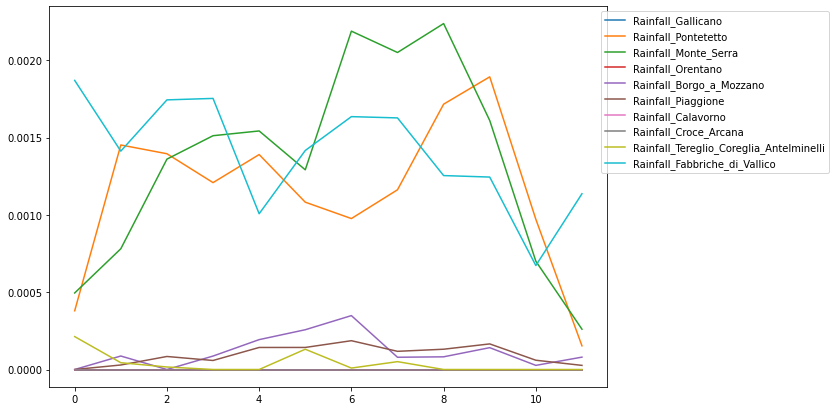

In [55]:
fig, ax = plt.subplots(figsize=(10,7))
for n in range(10):
    coef = [reg.coef_[i][0] for i in range(n,120,10)]
    ax.plot(coef, label=features[n])
    ax.legend(bbox_to_anchor=(0.98, 1), loc='upper left')

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'group_reg':[0.05, 0.02], 'l1_reg':[0.02,0.05]}

clf = GridSearchCV(model, parameters)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))


In [ ]:
list_an = ["cane", "gatto", "maiale"]
formato = "{} è un animale"
", ".join([formato.format(an) for an in list_an])

In [ ]:
x_train.columns